## EDA


In [2]:
import duckdb
import glob
import os

CLEANED_DIR = "/root/deduped_mix"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

total_rows = 0

for file in all_files:
    print(f"Counting rows in {os.path.basename(file)}")
    try:
        con = duckdb.connect()
        row_count = con.sql(f"SELECT COUNT(*) FROM '{file}'").fetchone()[0]
        print(f"{os.path.basename(file)} → {row_count:,} rows")
        total_rows += row_count
        con.close()
    except Exception as e:
        print(f"Skipped {os.path.basename(file)}: {e}")
        try:
            con.close()
        except:
            pass

print(f"\nTotal rows across all valid files: {total_rows:,}")


Counting rows in Video_Games_merged.parquet
Video_Games_merged.parquet → 4,570,965 rows
Counting rows in Amazon_Fashion_merged.parquet
Amazon_Fashion_merged.parquet → 2,475,694 rows
Counting rows in Software_merged.parquet
Software_merged.parquet → 4,829,120 rows
Counting rows in Health_and_Personal_Care_merged.parquet
Health_and_Personal_Care_merged.parquet → 488,990 rows
Counting rows in Arts_Crafts_and_Sewing_merged.parquet
Arts_Crafts_and_Sewing_merged.parquet → 8,876,382 rows
Counting rows in Home_and_Kitchen_merged.parquet
Home_and_Kitchen_merged.parquet → 66,610,259 rows
Counting rows in Handmade_Products_merged.parquet
Handmade_Products_merged.parquet → 656,784 rows
Counting rows in Baby_Products_merged.parquet
Baby_Products_merged.parquet → 5,967,958 rows
Counting rows in Unknown_merged.parquet
Unknown_merged.parquet → 63,813,972 rows
Counting rows in Electronics_merged.parquet
Electronics_merged.parquet → 43,374,274 rows
Counting rows in CDs_and_Vinyl_merged.parquet
CDs_and_V

Examining total amount of rows in dataset.

In [3]:
import duckdb
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

CLEANED_DIR = "/root/deduped_mix"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

# Connect once
con = duckdb.connect()


DUCKDB used for EDA bc of it's horizontal scaling.

Calculating star rating distribution...


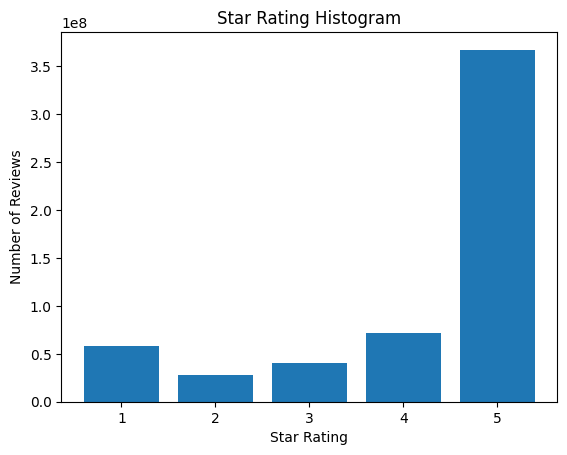

In [3]:
print("Calculating star rating distribution...")

star_rating_query = """
    SELECT rating, COUNT(*) AS count
    FROM read_parquet($files)
    WHERE rating BETWEEN 1 AND 5
    GROUP BY rating
    ORDER BY rating
"""
star_ratings = con.execute(star_rating_query, {'files': all_files}).fetchdf()

plt.bar(star_ratings['rating'], star_ratings['count'])
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Star Rating Histogram')
plt.show()


Calculating top 10 categories...


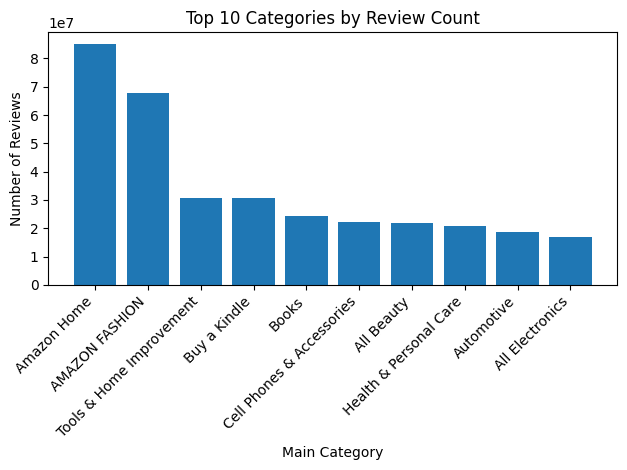

In [4]:
print("Calculating top 10 categories...")

category_query = """
    SELECT main_category, COUNT(*) AS count
    FROM read_parquet($files)
    WHERE main_category IS NOT NULL
    GROUP BY main_category
    ORDER BY count DESC
    LIMIT 10
"""
top_categories = con.execute(category_query, {'files': all_files}).fetchdf()

plt.bar(top_categories['main_category'], top_categories['count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Main Category')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Categories by Review Count')
plt.tight_layout()
plt.show()


Calculating top 10 brands...


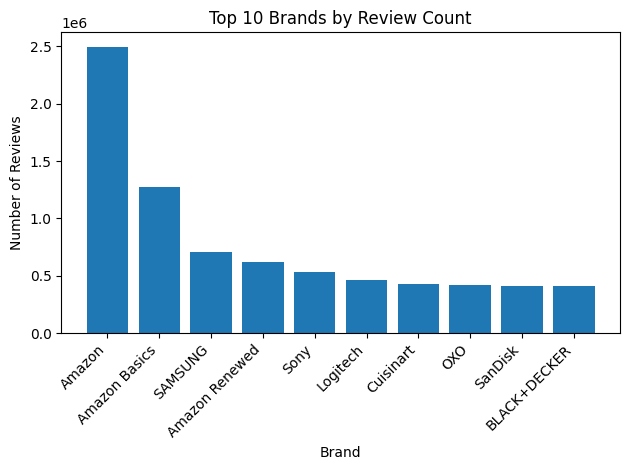

In [6]:
print("Calculating top 10 brands...")

brand_query = """
    SELECT brand, COUNT(*) AS count
    FROM read_parquet($files, union_by_name=True)
    WHERE brand IS NOT NULL AND brand != 'Unknown'
    GROUP BY brand
    ORDER BY count DESC
    LIMIT 10
"""
top_brands = con.execute(brand_query, {'files': all_files}).fetchdf()

plt.bar(top_brands['brand'], top_brands['count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Brand')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Brands by Review Count')
plt.tight_layout()
plt.show()


Calculating average star rating per year...


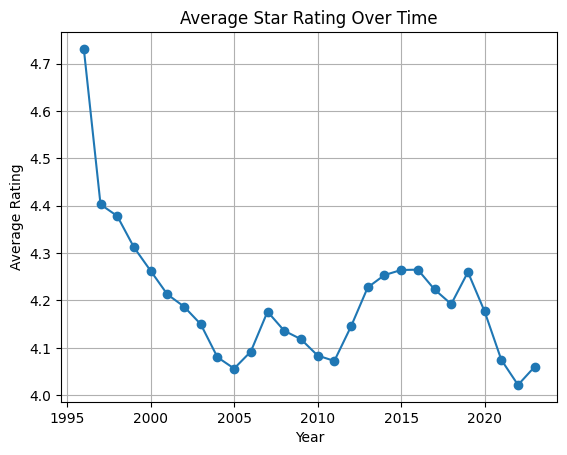

In [4]:
print("Calculating average star rating per year...")

time_trend_query = """
    SELECT year, AVG(rating) AS avg_rating
    FROM read_parquet($files, union_by_name = True)
    WHERE rating BETWEEN 1 AND 5 AND year IS NOT NULL
    GROUP BY year
    ORDER BY year
"""
avg_rating_per_year = con.execute(time_trend_query, {'files': all_files}).fetchdf()

plt.plot(avg_rating_per_year['year'], avg_rating_per_year['avg_rating'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Star Rating Over Time')
plt.grid()
plt.show()


In [1]:
print("Calculating Pearson correlation between review length and rating...")

correlation_query = """
    SELECT rating, review_length
    FROM read_parquet($files, union_by_name=True)
    WHERE rating BETWEEN 1 AND 5 AND review_length IS NOT NULL
"""
correlation_data = con.execute(correlation_query, {'files': all_files}).fetchdf()

pearson_corr = correlation_data['rating'].corr(correlation_data['review_length'])
print(f"Pearson correlation between review length and rating: {pearson_corr:.4f}")

# Interpretation
if pearson_corr > 0:
    print("Interpretation: There is a positive correlation. Longer reviews slightly tend to have higher ratings.")
elif pearson_corr < 0:
    print("Interpretation: There is a negative correlation. Longer reviews slightly tend to have lower ratings.")
else:
    print("Interpretation: There is no correlation between review length and rating.")


Calculating Pearson correlation between review length and rating...


NameError: name 'con' is not defined